In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.patches as mpatches

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 'code')
from help_funcs import *

import matplotlib

matplotlib.rcParams.update({'font.size': 18})

In [31]:
sstcolor = (0.898,0.6314,0.0039)
pvcolor = (0.0, 0.4039, 0.7059)

In [2]:
import scipy.stats

def periodic_distance(p1, p2, L=1.0):
    """
    Calculates the periodic distance between two points on a 1x1 2-dimensional plane.

    Parameters
    ----------
    p1 : numpy array
        The first point, with shape (2,).
    p2 : numpy array
        The second point, with shape (2,).
    L : float
        The length of the periodic boundary, default value is 1.0.

    Returns
    -------
    distance : float
        The periodic distance between two points.
    """
    delta = np.abs(p1 - p2)
    delta = np.where(delta > L/2, L - delta, delta)
    return np.sqrt(np.sum(delta**2))


def getStimRateMeans(exc_spikes, exc_positions, rates=False, nsecs = 10, binlen = 100):
    # store the control times and the chr2 stimulation times
    control_times = []
    chr_times = []
    ii = 0
    is_control = True
    while True:
        start_time = ii * 500 + 1000
        stop_time = start_time + binlen
        if stop_time > nsecs*1000: break
        if is_control:
            control_times.append(start_time)
        else:
            chr_times.append(start_time)   
        ii += 1
        if is_control:
            is_control = False
        else:
            is_control = True        
        
    assert len(control_times) == len(chr_times)
#     print("NTIMES:", control_times, chr_times)
    # compute the rates of the cells distal to the chr2 stimulus
    control_spikes = []
    chr_spikes = []
    center_pos = np.array([0.5,0.5])
    for ni in range(len(exc_positions)):
        pos_x, pos_y = exc_positions[ni,:]
        dist = np.sqrt((0.5-pos_x)**2 + (0.5-pos_y)**2)
        if dist > 0.25:
            continue
        nspikes = 0
        for tim in control_times:
            aa = exc_spikes[ni] [exc_spikes[ni] > tim ]
            aa = aa [aa < tim+binlen]
            nspikes += len(aa)
        control_spikes.append(nspikes)

        nspikes = 0
        for tim in chr_times:
            aa = exc_spikes[ni] [exc_spikes[ni] > tim ]
            aa = aa [aa < tim+binlen]
            nspikes += len(aa)
        chr_spikes.append(nspikes)
    control_rates = np.divide(control_spikes,(binlen/1000)*len(control_times)) # convert from spike count to rate
    chr_rates = np.divide(chr_spikes,(binlen/1000)*len(chr_times))
    ctrl_mean = np.mean(control_rates)
    chr2_mean = np.mean(chr_rates)
    
    ctrl_err = scipy.stats.sem(control_rates)
    chr2_err = scipy.stats.sem(chr_rates)
    
    if rates:
        return [ctrl_mean, chr2_mean, ctrl_err, chr2_err, control_rates, chr_rates]
    else:
        return [ctrl_mean, chr2_mean, ctrl_err, chr2_err]
    

def getSpontMedians(all_spikes, start_time = 1000., stop_time = 10000.):
    
    exc_spikes = all_spikes[:8000]
    pv_spikes = all_spikes[8000:9000]
    sst_spikes = all_spikes[9000:]
    
    tlen = (stop_time - start_time)/1000.
    
    exc_nspikes = []
    for spikes in exc_spikes:
        aa = spikes[spikes > start_time ]
        aa = aa [aa < stop_time]
        exc_nspikes.append(len(aa)/tlen)
        
    pv_nspikes = []
    for spikes in pv_spikes:
        aa = spikes[spikes > start_time ]
        aa = aa [aa < stop_time]
        pv_nspikes.append(len(aa)/tlen)
        
    sst_nspikes = []
    for spikes in sst_spikes:
        aa = spikes[spikes > start_time ]
        aa = aa [aa < stop_time]
        sst_nspikes.append(len(aa)/tlen)
        
    return np.median(exc_nspikes), np.median(pv_nspikes), np.median(sst_nspikes)

In [3]:
import numpy as np
from scipy.optimize import curve_fit

# naka-rushton = (m+((Rm.*(x.^n))./((x.^n) + (c50.^n)))))
# parameter = [Rm, n, c50, m]
# p0 = [150, 5, 0.1, 50]
# Upper = [250, 30, 0.26, 200]
# Lower = [0, 0, 0.04, 0]
p0 = [50, 150, 5, 0.1] 
Upper = [200, 250, 15, 0.2]
# Lower = [0, 0, 0, 0.04]
Lower = [0, 0, 0, 0.05]
bounds = (Lower, Upper)

def naka_rushton(x, m, C, n, k):
    return m + C * (x**n) / (x**n + k**n)

def fit_naka_rushton(x, y, sigma=None, p0 = p0, bounds=bounds):
    params, cov = curve_fit(naka_rushton, x, y, bounds=bounds, sigma=sigma, p0=p0, maxfev = 1000000)
    return params, cov


In [4]:
simname = 'short_nl'
contrasts = np.array([0.02, 0.05, 0.1, 0.18, 0.33])
# contrasts = np.array([0.02, 0.05, 0.1, 0.18])
ignor=0
binlen = 60

def get_slope(m,C,n,k):
    cvals = np.arange(0.02,0.33,0.01)
    yvals = naka_rushton(cvals, m, C, n, k)
    
    slopes = []
    for i in range(1, len(cvals)):
        slopes.append((yvals[i]-yvals[i-1])/0.01)
    maxslope = np.max(slopes)
    return maxslope, cvals[slopes.index(maxslope)]

def get_slope_change(simname, seed):

    ctrl_pv_curve = [[] for i in range(4)]
    stim_pv_curve = [[] for i in range(4)]
    ctrl_sst_curve = [[] for i in range(4)]
    stim_sst_curve = [[] for i in range(4)]

    ctrl_pv_curve_e = [[] for i in range(4)]
    stim_pv_curve_e = [[] for i in range(4)]
    ctrl_sst_curve_e = [[] for i in range(4)]
    stim_sst_curve_e = [[] for i in range(4)]

    
    folder = 'data/%s/results_%s/'%(simname, seed)
    not_all_found=False
    for cont in contrasts:
        with open(folder + 'PV_%s_spikes.pickle'%cont, 'rb') as f:
            all_spikes = pickle.load(f)
        with open(folder + 'PV_%s_positions.pickle'%cont, 'rb') as f:
            all_positions = pickle.load(f)


        ctrlpv_E_mean, stimpv_E_mean, ctrlpv_E_err, stimpv_E_err = getStimRateMeans(all_spikes[:8000], all_positions[:8000], binlen=binlen)
        ctrlpv_P_mean, stimpv_P_mean, ctrlpv_P_err, stimpv_P_err = getStimRateMeans(all_spikes[8000:9000], all_positions[8000:9000], binlen=binlen)
        ctrlpv_S_mean, stimpv_S_mean, ctrlpv_S_err, stimpv_S_err = getStimRateMeans(all_spikes[9000:10000], all_positions[9000:10000], binlen=binlen)
        ctrlpv_A_mean, stimpv_A_mean, ctrlpv_A_err, stimpv_A_err = getStimRateMeans(all_spikes, all_positions, binlen=binlen)

        ctrl_pv_curve[0].append(ctrlpv_E_mean)
        ctrl_pv_curve[1].append(ctrlpv_P_mean)
        ctrl_pv_curve[2].append(ctrlpv_S_mean)
        ctrl_pv_curve[3].append(ctrlpv_A_mean)
        ctrl_pv_curve_e[0].append(ctrlpv_E_err)
        ctrl_pv_curve_e[1].append(ctrlpv_P_err)
        ctrl_pv_curve_e[2].append(ctrlpv_S_err)
        ctrl_pv_curve_e[3].append(ctrlpv_A_err)

        stim_pv_curve[0].append(stimpv_E_mean)
        stim_pv_curve[1].append(stimpv_P_mean)
        stim_pv_curve[2].append(stimpv_S_mean)
        stim_pv_curve[3].append(stimpv_A_mean)
        stim_pv_curve_e[0].append(stimpv_E_err)
        stim_pv_curve_e[1].append(stimpv_P_err)
        stim_pv_curve_e[2].append(stimpv_S_err)
        stim_pv_curve_e[3].append(stimpv_A_err)


        with open(folder + 'SOM_%s_spikes.pickle'%cont, 'rb') as f:
            all_spikes = pickle.load(f)
        with open(folder + 'SOM_%s_positions.pickle'%cont, 'rb') as f:
            all_positions = pickle.load(f)


        ctrlsst_E_mean, stimsst_E_mean, ctrlsst_E_err, stimsst_E_err = getStimRateMeans(all_spikes[:8000], all_positions[:8000], binlen= binlen)
        ctrlsst_P_mean, stimsst_P_mean, ctrlsst_P_err, stimsst_P_err = getStimRateMeans(all_spikes[8000:9000], all_positions[8000:9000], binlen= binlen)
        ctrlsst_S_mean, stimsst_S_mean, ctrlsst_S_err, stimsst_S_err = getStimRateMeans(all_spikes[9000:10000], all_positions[9000:10000], binlen= binlen)
        ctrlsst_A_mean, stimsst_A_mean, ctrlsst_A_err, stimsst_A_err = getStimRateMeans(all_spikes, all_positions, binlen= binlen)


        ctrl_sst_curve[0].append(ctrlsst_E_mean)
        ctrl_sst_curve[1].append(ctrlsst_P_mean)
        ctrl_sst_curve[2].append(ctrlsst_S_mean)
        ctrl_sst_curve[3].append(ctrlsst_A_mean)
        ctrl_sst_curve_e[0].append(ctrlsst_E_err)
        ctrl_sst_curve_e[1].append(ctrlsst_P_err)
        ctrl_sst_curve_e[2].append(ctrlsst_S_err)
        ctrl_sst_curve_e[3].append(ctrlsst_A_err)

        stim_sst_curve[0].append(stimsst_E_mean)
        stim_sst_curve[1].append(stimsst_P_mean)
        stim_sst_curve[2].append(stimsst_S_mean)
        stim_sst_curve[3].append(stimsst_A_mean)
        stim_sst_curve_e[0].append(stimsst_E_err)
        stim_sst_curve_e[1].append(stimsst_P_err)
        stim_sst_curve_e[2].append(stimsst_S_err)
        stim_sst_curve_e[3].append(stimsst_A_err)
 
    params, cov = fit_naka_rushton(contrasts[ignor:], ctrl_pv_curve[3][ignor:], sigma=ctrl_pv_curve_e[3][ignor:])
    m_cp, C_cp, n_cp, k_cp = params
    m_cp_err, C_cp_err, n_cp_err, k_cp_err = np.sqrt(np.diag(cov))
#     slope_cp = C_cp*n_cp/k_cp/4.0
    slope_cp, _ = get_slope(m_cp, C_cp, n_cp, k_cp)
    
    params, cov = fit_naka_rushton(contrasts[ignor:], stim_pv_curve[3][ignor:], sigma=stim_pv_curve_e[3][ignor:])
    m_sp, C_sp, n_sp, k_sp = params
    m_sp_err, C_sp_err, n_sp_err, k_sp_err = np.sqrt(np.diag(cov))
#     slope_sp = C_sp*n_sp/k_sp/4.0
    slope_sp, _ = get_slope(m_sp, C_sp, n_sp, k_sp)
    
    params, cov = fit_naka_rushton(contrasts[ignor:], ctrl_sst_curve[3][ignor:], sigma=ctrl_sst_curve_e[3][ignor:])
    m_cs, C_cs, n_cs, k_cs = params
    m_cs_err, C_cs_err, n_cs_err, k_cs_err = np.sqrt(np.diag(cov))
#     slope_cs = C_cs*n_cs/k_cs/4.0
    slope_cs, _ = get_slope(m_cs, C_cs, n_cs, k_cs)
    
    params, cov = fit_naka_rushton(contrasts[ignor:], stim_sst_curve[3][ignor:], sigma=stim_sst_curve_e[3][ignor:])
    m_ss, C_ss, n_ss, k_ss = params
    m_ss_err, C_ss_err, n_ss_err, k_ss_err = np.sqrt(np.diag(cov))
#     slope_ss = C_ss*n_ss/k_ss/4.0
    slope_ss, _ = get_slope(m_ss, C_ss, n_ss, k_ss)
    
    
    change_pv = ( slope_sp - slope_cp ) / (slope_cp + slope_sp)
    change_sst = ( slope_ss - slope_cs ) / (slope_cs + slope_ss)
    
    return change_pv, change_sst

In [5]:
get_slope_change('nl3t', 2)

(0.07660713143958944, -0.09298967220531257)

In [6]:
long_names = ['base3t', 'vnl_0.0025', 'vnl_0.005', 'vnl_0.0075', 'vnl_0.01', 'vnl_0.0125', 'vnl_0.015', 'vnl_0.0175', 'nl3t' ]
short_names = [ 'vnl_0.2_0.0001','vnl_0.2_0.0025', 'vnl_0.2_0.005', 'vnl_0.2_0.0075', 'vnl_0.2_0.01', 'vnl_0.2_0.0125', 'vnl_0.2_0.015', 'vnl_0.2_0.0175', 'short_nl' ]

In [30]:
pv_long = []
sst_long = []
pv_long_errs = []
sst_long_errs = []
for ai in range(len(long_names)):
    pv_changes, sst_changes = [], []
    for seed in range(10):
        sim_name = long_names[ai]
        try: 
            pv_c, sst_c = get_slope_change(sim_name, seed)
        except FileNotFoundError:
            continue
        pv_changes.append(pv_c)
        sst_changes.append(sst_c)
        print('seed', seed, pv_c, sst_c)
    print(ai, len(pv_changes), len(sst_changes))
        
    pv_long.append(np.mean(pv_changes))
    sst_long.append(np.mean(sst_changes))
    pv_long_errs.append(scipy.stats.sem(pv_changes))
    sst_long_errs.append(scipy.stats.sem(sst_changes))

seed 1 -0.1329044764095078 -0.17352226813285185
seed 2 0.052803753316378474 -0.08558180158802721
seed 3 0.16252604965127898 -0.4153235862287422
seed 4 0.019173861290345207 -0.3844880610529927
seed 5 -0.11195355583447798 -0.18964992228814007
seed 6 -0.35296692021759196 -0.15814871491100885
seed 7 -0.02395669732308429 -0.10453548575253498
seed 8 -0.21061577588571448 0.21039418537109797
seed 9 0.07610850779158088 0.03140075044253401
0 9 9
seed 1 0.02240516779018828 0.03559837622389919
seed 2 -0.01633585837816525 -0.086854064612059
seed 3 0.08994632471268198 -0.03453326241772845
seed 4 0.005872104933560056 -0.11206938512832866
seed 5 0.10704486263552952 0.1503793708411105
seed 6 0.005007602890450224 -0.11713297474430542
seed 7 0.24602838713196123 -0.02257262976295209
seed 8 0.21605937302930153 0.08843702530972024
seed 9 0.03552956479674964 -0.05708775290951399
1 9 9
seed 1 0.13668992012605666 0.02758311157061985
seed 2 0.0749762732624565 -0.0857143752604437
seed 3 0.09789969233084521 -0.01

In [16]:
len(sst_long)

9

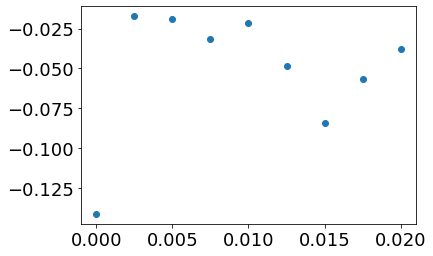

In [17]:
plt.scatter([0.0025*i for i in range(9)], sst_long)

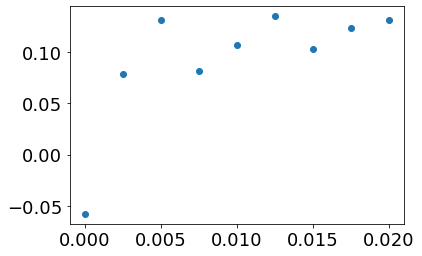

In [18]:
plt.scatter([0.0025*i for i in range(9)], pv_long)

In [26]:
long_names

['base3t',
 'vnl_0.0025',
 'vnl_0.005',
 'vnl_0.0075',
 'vnl_0.01',
 'vnl_0.0125',
 'vnl_0.015',
 'vnl_0.0175',
 'nl3t']

In [7]:
pv_short = []
sst_short = []

pv_short_errs = []
sst_short_errs = []
for ai in range(len(short_names)):
    pv_changes, sst_changes = [], []
    for seed in range(10):
        sim_name = short_names[ai]
        try: 
            pv_c, sst_c = get_slope_change(sim_name, seed)
        except FileNotFoundError:
            continue
        pv_changes.append(pv_c)
        sst_changes.append(sst_c)
        print('seed', seed, pv_c, sst_c)
    print(ai, len(pv_changes), len(sst_changes))
        
        
    pv_short.append(np.mean(pv_changes))
    sst_short.append(np.mean(sst_changes))
    pv_short_errs.append(scipy.stats.sem(pv_changes))
    sst_short_errs.append(scipy.stats.sem(sst_changes))

seed 1 0.007086261363605607 0.04875971878339672
seed 2 0.029100993217605956 -0.05333928024198103
seed 3 0.04722562729049161 -0.018515183481494935
seed 4 -0.07010553290192167 0.06723492402982631
seed 5 0.08724081266769153 -0.025508250940970357
seed 6 0.000229871804465608 -0.06510789749242707
seed 7 0.15607540223209831 0.10106574940602298
seed 8 0.21067162629154965 0.13764614046005258
seed 9 0.07714142485739077 -0.018507947723239757
0 9 9
seed 1 0.07706100672162906 0.016661055105195655
seed 2 0.07277665158653589 -0.028626578645473057
seed 3 0.07021732328567415 -0.025696763991865497
seed 4 -0.01760790649022926 -0.028882717012912243
seed 5 -0.003497776770714496 0.05753560540174651
seed 6 0.04463713050930781 -0.05236654516201767
seed 7 0.20736458348154888 0.07370087807906182
seed 8 0.2336868795060058 0.12901564005798094
seed 9 -0.0019932326257252617 -0.03363592494612335
1 9 9
seed 1 0.09618103333620137 0.07184131293632673
seed 2 0.039556100023863436 -0.03635456217324594
seed 3 0.09494140011

Text(0.5, 0, '$α$ (nS$^{-1}$)')

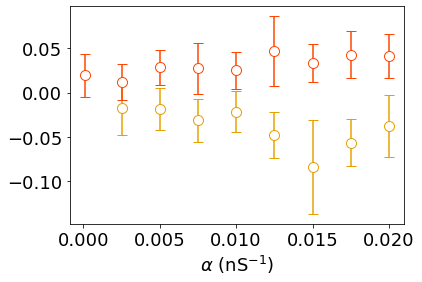

In [41]:
fig, ax = plt.subplots()
xvals = [0.0025*i for i in range(1,9)]
ax.errorbar(xvals, sst_long[1:], yerr = sst_long_errs[1:], fmt = 'o', ecolor = sstcolor, capsize = 5, markeredgecolor = sstcolor, markersize = 10, markerfacecolor='white')

xvals = [0.0001]+[0.0025*i for i in range(1,9)]
ax.errorbar(xvals, sst_short, yerr = sst_short_errs, fmt = 'o', ecolor = 'orangered', capsize = 5, markeredgecolor = 'orangered', markersize = 10, markerfacecolor='white')

ax.set_xlabel('$α$ (nS$^{-1}$)')
ax.set_yaabel

In [34]:
1/0.015

66.66666666666667